In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pylab as plt

from scipy.stats import ttest_ind
import scipy.stats as ss

import warnings
warnings.filterwarnings('ignore')

### Import Data

In [2]:
test = pd.read_csv('C:/Sophia/School!!!/2023 Spring 1/DS take home/17.engagement/test_table.csv', parse_dates=['date'])
test.head()

,user_id,date,browser,test,pages_visited
0,600597,2015-08-13,IE,0,2
1,4410028,2015-08-26,Chrome,1,5
2,6004777,2015-08-17,Chrome,0,8
3,5990330,2015-08-27,Safari,0,8
4,3622310,2015-08-07,Firefox,0,1


In [3]:
user = pd.read_csv('C:/Sophia/School!!!/2023 Spring 1/DS take home/17.engagement/user_table.csv', parse_dates=['signup_date'])
user.head()

,user_id,signup_date
0,34,2015-01-01
1,59,2015-01-01
2,178,2015-01-01
3,285,2015-01-01
4,383,2015-01-01


In [4]:
# join user and test table
data = pd.merge(left=test, right=user, on='user_id', how='left')
data.head()

,user_id,date,browser,test,pages_visited,signup_date
0,600597,2015-08-13,IE,0,2,2015-01-19
1,4410028,2015-08-26,Chrome,1,5,2015-05-11
2,6004777,2015-08-17,Chrome,0,8,2015-06-26
3,5990330,2015-08-27,Safari,0,8,2015-06-25
4,3622310,2015-08-07,Firefox,0,1,2015-04-17


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        100000 non-null  int64         
 1   date           100000 non-null  datetime64[ns]
 2   browser        100000 non-null  object        
 3   test           100000 non-null  int64         
 4   pages_visited  100000 non-null  int64         
 5   signup_date    100000 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 5.3+ MB


### Question 1
Is the test winning? That is, should 100% of the users see the Recommended Friends feature?

In [6]:
data.groupby('test')['pages_visited'].mean()

test
0    4.608394
1    4.599693
Name: pages_visited, dtype: float64

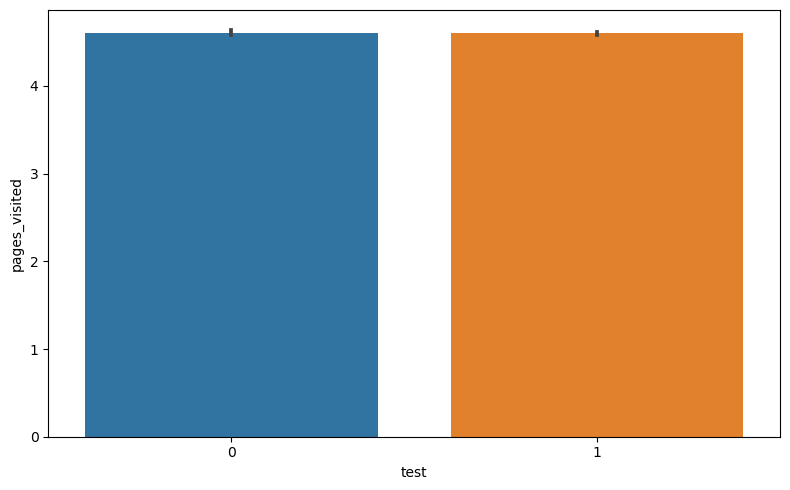

In [7]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(x='test', y='pages_visited', data=data, ax=ax)
plt.tight_layout()
plt.show()

In [8]:
# perform student's t-test
control_page = data[data['test'] == 0]['pages_visited'].values
experiment_page = data[data['test'] == 1]['pages_visited'].values

print('T-test:\t', ttest_ind(a=control_page, b=experiment_page, equal_var=False))

T-test:	 Ttest_indResult(statistic=0.5571118435554797, pvalue=0.5774523171559118)


From above analysis, we can find that p-value is 0.577, which is larger than 0.05, so we cannot reject the null hypothesis. That is, there is no difference between control and experiment group.

Hence, the test doesn't win at tall. The Recommended Friends feature shouldn't expand to all users.

### Question 2
Is the test performing similarly for all user segments or are there differences among different segments?

In [9]:
data['interval'] = (data['date'] - data['signup_date']).apply(lambda x: x.days)
data['is_first'] = (data['interval'] == 0).astype(int)
data['dayofweek'] = data['date'].apply(lambda x: x.dayofweek)

data.head()

,user_id,date,browser,test,pages_visited,signup_date,interval,is_first,dayofweek
0,600597,2015-08-13,IE,0,2,2015-01-19,206,0,3
1,4410028,2015-08-26,Chrome,1,5,2015-05-11,107,0,2
2,6004777,2015-08-17,Chrome,0,8,2015-06-26,52,0,0
3,5990330,2015-08-27,Safari,0,8,2015-06-25,63,0,3
4,3622310,2015-08-07,Firefox,0,1,2015-04-17,112,0,4


In [10]:
def run_ttest(df):
    vp_in_test = df.loc[data.test == 1, 'pages_visited']
    test_mean = vp_in_test.mean()
    
    vp_in_ctrl = df.loc[data.test == 0, 'pages_visited']
    ctrl_mean = vp_in_ctrl.mean()
    
    result = ss.ttest_ind(vp_in_ctrl, vp_in_test, equal_var=False)
    conclusion = 'Significant' if result.pvalue < 0.05 else 'Not Significant'
    
    return pd.Series({'n_test':vp_in_test.shape[0],
                      'n_ctrl': vp_in_ctrl.shape[0],
                      'mean_test': test_mean,
                      'mean_ctrl': ctrl_mean,
                      'test-ctrl': test_mean - ctrl_mean,
                      'pvalue':result.pvalue,
                      'conclusion':conclusion})

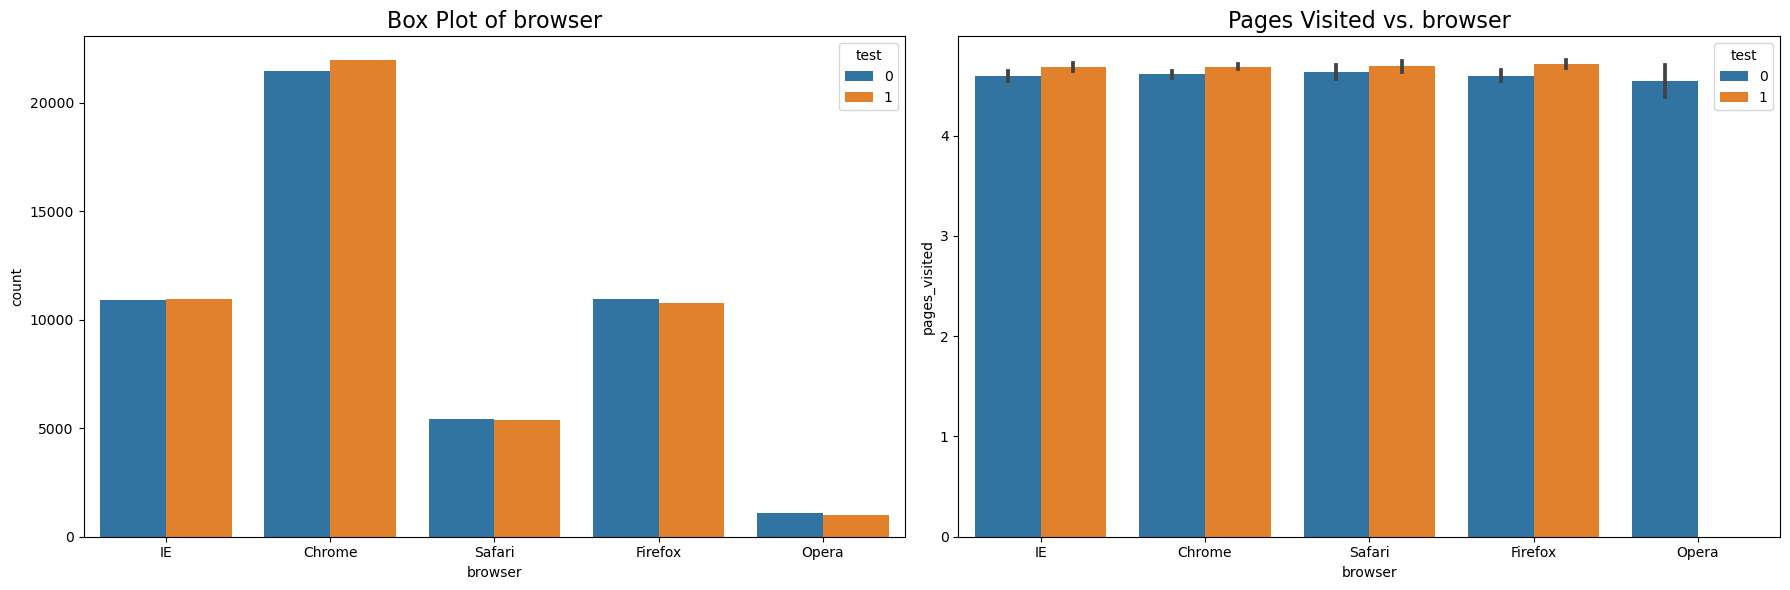

In [11]:
# visualization of browser
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='browser', hue='test', data=data, ax=ax[0])
ax[0].set_title('Box Plot of browser', fontsize=16)

sns.barplot(x='browser', y='pages_visited', hue='test', data=data, ax=ax[1])
ax[1].set_title('Pages Visited vs. browser', fontsize=16)
plt.tight_layout()
plt.show()

In [12]:
data.groupby('browser').apply(run_ttest)

,n_test,n_ctrl,mean_test,mean_ctrl,test-ctrl,pvalue,conclusion
browser,,,,,,,
Chrome,21974,21453,4.690680,4.613341,0.077339,9.434084e-04,Significant
Firefox,10786,10972,4.714259,4.600164,0.114095,5.817199e-04,Significant
IE,10974,10906,4.685985,4.598478,0.087507,7.829509e-03,Significant
Opera,1018,1109,0.000000,4.546438,-4.546438,2.252939e-321,Significant
Safari,5402,5406,4.692336,4.638180,0.054156,2.411738e-01,Not Significant


- page_visited in Chrome, Firefox, IE are significantly increased.
- page_visited in Opera has reduced to zero, maybe there is some bug in implementation on Opera, which stops user visiting further pages.
- page_visited in Safari has no significant improvement, maybe because the recommended friends aren't shown in a noticeable position.

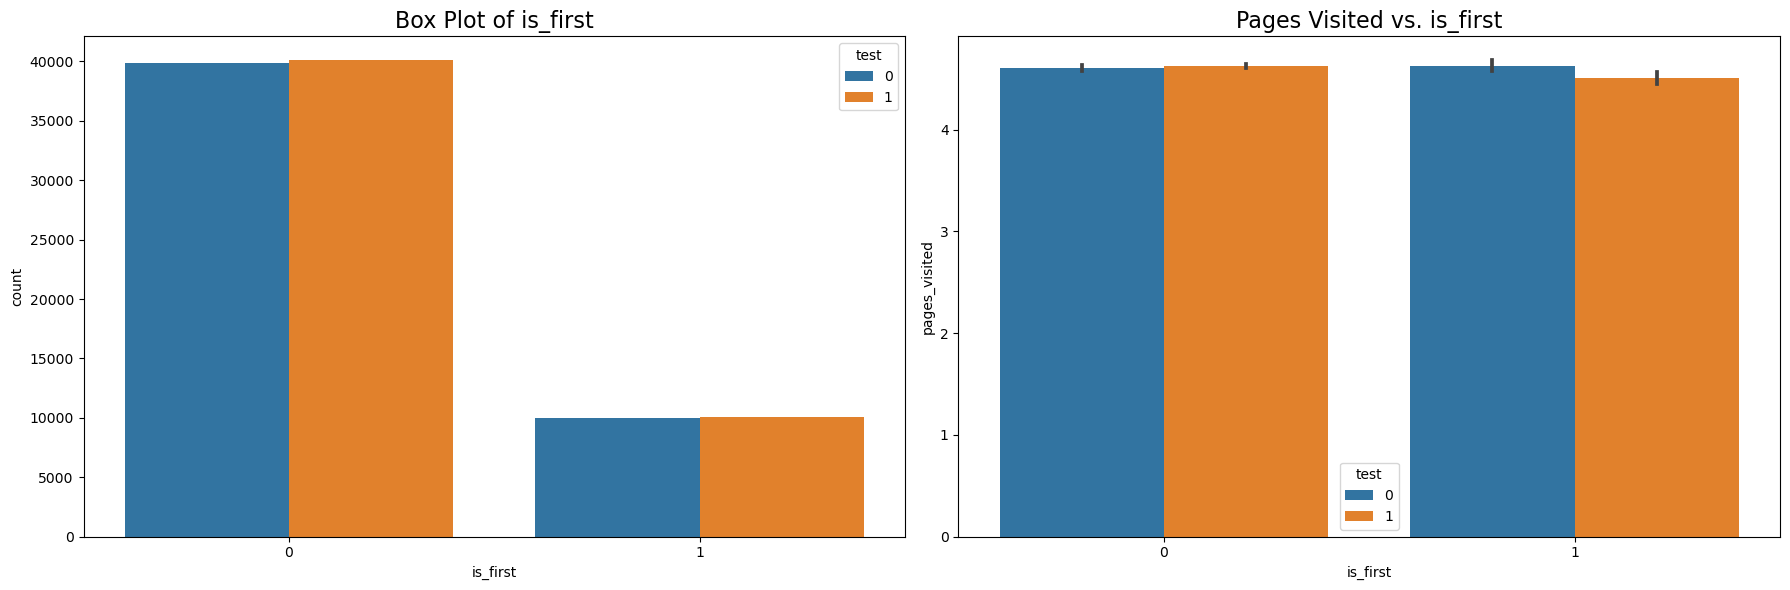

In [13]:
# visualization of is_first
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='is_first', hue='test', data=data, ax=ax[0])
ax[0].set_title('Box Plot of is_first', fontsize=16)

sns.barplot(x='is_first', y='pages_visited', hue='test', data=data, ax=ax[1])
ax[1].set_title('Pages Visited vs. is_first', fontsize=16)
plt.tight_layout()
plt.show()

In [14]:
data.groupby('is_first').apply(run_ttest)

,n_test,n_ctrl,mean_test,mean_ctrl,test-ctrl,pvalue,conclusion
is_first,,,,,,,
0,40109,39890,4.622379,4.603284,0.019095,0.261837,Not Significant
1,10045,9956,4.509109,4.628867,-0.119758,0.001742,Significant


- For old users, the new feature improve # of page_visted, but the change isn't significant
- For first-time new users, this new feature significantly decrease # of page_visited.

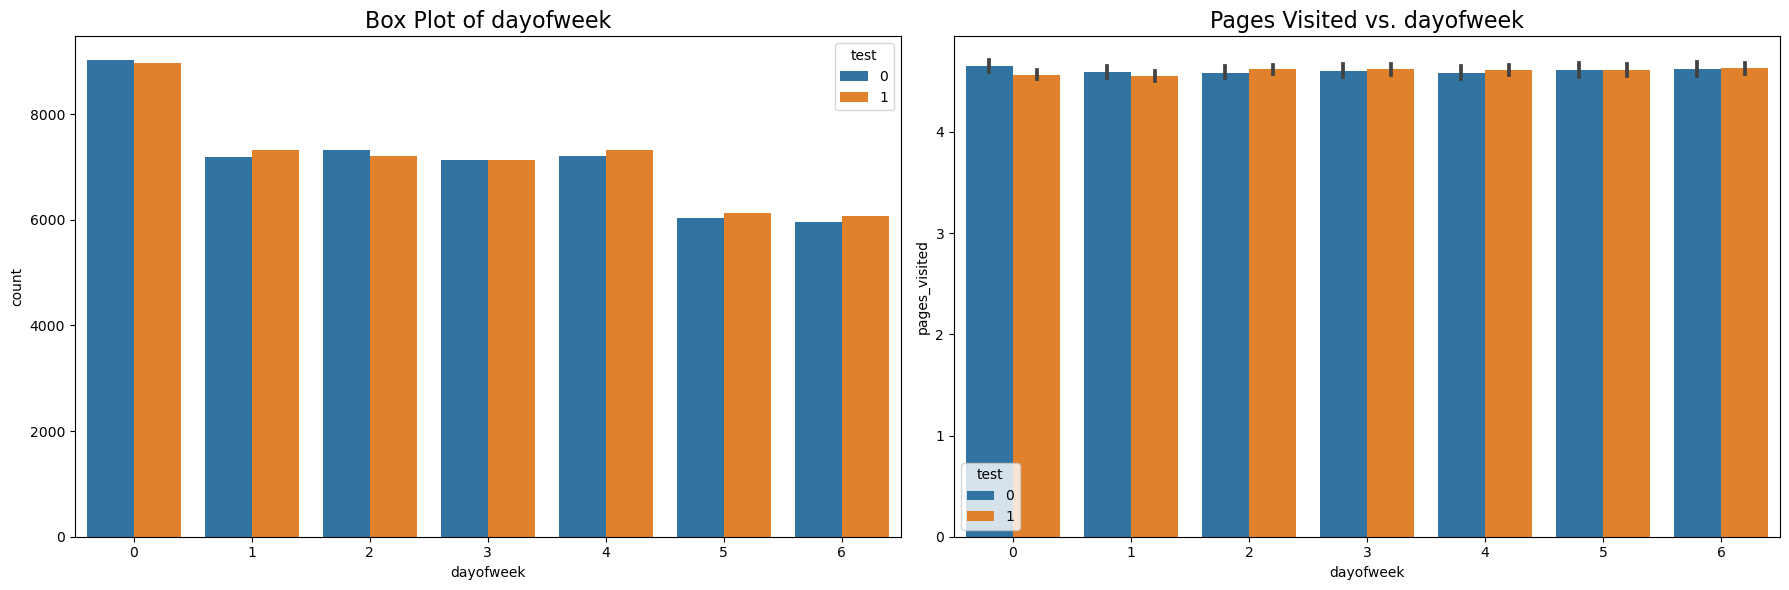

In [15]:
# visualization of dayofweek
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='dayofweek', hue='test', data=data, ax=ax[0])
ax[0].set_title('Box Plot of dayofweek', fontsize=16)

sns.barplot(x='dayofweek', y='pages_visited', hue='test', data=data, ax=ax[1])
ax[1].set_title('Pages Visited vs. dayofweek', fontsize=16)
plt.tight_layout()
plt.show()

### Question 3
If you identified segments that responded differently to the test, can you guess the reason? Would this change your point 1 conclusions?

The number of pages visited is always 0 for Opera, which shows that there might be some errors or bugs. We remove the user who use Opera, and conduct t-test again.

In [16]:
data = data[data['browser'] != 'Opera']

In [17]:
run_ttest(data)

n_test              49136
n_ctrl              48737
mean_test        4.694989
mean_ctrl        4.609804
test-ctrl        0.085186
pvalue                0.0
conclusion    Significant
dtype: object

It's clear that after removing the records with Opera browser, the new feature becomes significantly useful. Hence, we would suggest expanding this feature to other users.

In [18]:
data.groupby('browser').apply(run_ttest)

,n_test,n_ctrl,mean_test,mean_ctrl,test-ctrl,pvalue,conclusion
browser,,,,,,,
Chrome,21974,21453,4.690680,4.613341,0.077339,0.000943,Significant
Firefox,10786,10972,4.714259,4.600164,0.114095,0.000582,Significant
IE,10974,10906,4.685985,4.598478,0.087507,0.007830,Significant
Safari,5402,5406,4.692336,4.638180,0.054156,0.241174,Not Significant


In [19]:
data.groupby(['browser','is_first']).apply(run_ttest)

n_test  n_ctrl  mean_test  mean_ctrl  test-ctrl    pvalue  \
browser is_first                                                              
Chrome  0          17525   17092   4.701512   4.607945   0.093567  0.000229   
        1           4449    4361   4.648011   4.634488   0.013523  0.814918   
Firefox 0           8657    8842   4.757306   4.590590   0.166716  0.000004   
        1           2129    2130   4.539220   4.639906  -0.100686  0.221071   
IE      0           8779    8744   4.721494   4.590576   0.130918  0.000267   
        1           2195    2162   4.543964   4.630435  -0.086471  0.280842   
Safari  0           4315    4329   4.720973   4.638254   0.082720  0.100083   
        1           1087    1077   4.578657   4.637883  -0.059226  0.601524   

                       conclusion  
browser is_first                   
Chrome  0             Significant  
        1         Not Significant  
Firefox 0             Significant  
        1         Not Significant  
IE      0             Significant  
        1         Not Significant  
Safari  0         Not Significant  
        1         Not Significant

Besides Opera which may have a bug, all changes for new users are not significant, and there is even some drop after applying this new feature.

This may because: the friend recommendation engine may be based on a user's previous social activity on the site. then for new users, since they don't have any previous history for recommendation engine to use, the recommendation result is like random guess, which cannot draw new user's interest. But the recommended friends may occupy some space on the page, so it may even decrease the #page_visited for new users a little bit.

From this observation, we suspect the Recommedation Engine suffers 'the cold start' problem.